In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import preprocessing

1. Загружаем Mushrooms, делаем DataFrame

Вычисляем распределение признаков по классам

Визуализируем распределение

In [2]:
mashrooms = pd.read_csv('mushrooms.csv')

In [3]:
percentage_df = []
properties = mashrooms.drop(columns=['class']).columns

for one_prop in properties:
    temp_df = mashrooms[['class', one_prop]]
    result = temp_df.groupby('class').value_counts(normalize=True).reset_index()
    result = result.rename(columns={one_prop: 'property_data', 0: 'propery_percentage'})
    result['property_name'] = one_prop
    percentage_df.append(result)

percentage_df = pd.concat(percentage_df)

In [4]:
percentage_df[percentage_df['property_name'] == properties[4]]

,class,property_data,propery_percentage,property_name
0,e,n,0.809886,odor
1,e,a,0.095057,odor
2,e,l,0.095057,odor
3,p,f,0.551583,odor
4,p,s,0.147089,odor
5,p,y,0.147089,odor
6,p,p,0.065373,odor
7,p,c,0.049030,odor
8,p,n,0.030644,odor
9,p,m,0.009193,odor


0'cap-shape', 1'cap-surface', 2'cap-color', 3'bruises', 4'odor',
5'gill-attachment', 6'gill-spacing', 7'gill-size', 8'gill-color',
9'stalk-shape', 10'stalk-root', 11'stalk-surface-above-ring',
12'stalk-surface-below-ring', 13'stalk-color-above-ring',
14'stalk-color-below-ring', 15'veil-type', 16'veil-color', 17'ring-number',
18'ring-type', 19'spore-print-color', 20'population', 21'habitat'

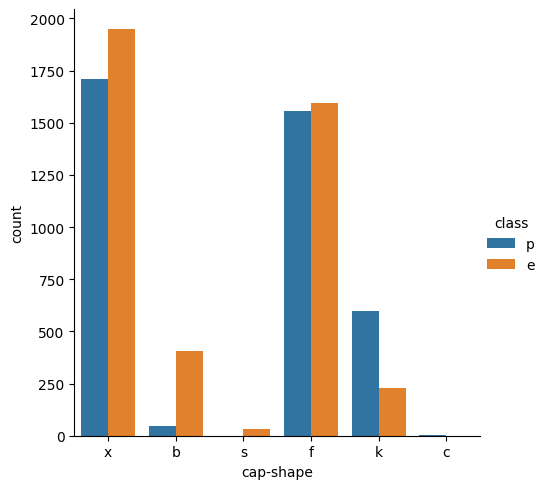

In [5]:
to_visual = properties[0]
sns.catplot(x = to_visual, data=mashrooms, hue='class',kind = 'count' )

2. Построить решающую функцию по каждой переменной на основе частот

вычислить точность каждого решения

найти наиболее информативную переменную

In [6]:
X = mashrooms.drop(columns=['class'])
y = mashrooms['class']

In [7]:
y.value_counts(normalize=True).reset_index()

,index,class
0,e,0.517971
1,p,0.482029


In [8]:
def get_prob_col(column,j, alpha = 0):
    global X
    global y
    prob = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob
    
def predict(X,column):
    global y
    y_pred = []
    prob0 = get_prob_col(column,'e')
    prob1 = get_prob_col(column,'p')
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    for k in X[column]:
        if p0 * prob0[k] < p1 * prob1[k]:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return np.array(y_pred)

In [9]:
results = {
    'column_name': list(),
    'score_train': list()
}
for col in X.columns:
    results['column_name'].append(col)
    results['score_train'].append(accuracy_score(y, predict(X,col)))
results_df = pd.DataFrame(results)

In [10]:
results_df.sort_values('score_train', ascending=False)
# gill-color

,column_name,score_train
4,odor,0.985229
19,spore-print-color,0.868045
8,gill-color,0.805022
18,ring-type,0.775480
11,stalk-surface-above-ring,0.774495
12,stalk-surface-below-ring,0.766125
7,gill-size,0.756278
3,bruises,0.743968
20,population,0.721812
13,stalk-color-above-ring,0.716396


3. Наивный байесовский классификатор из sklearn

In [11]:
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)
model = sklearn.naive_bayes.CategoricalNB(alpha=5).fit(X_c,y_c)
print(accuracy_score(y_c, model.predict(X_c)))

0.9405465288035451


4. написать самому

In [12]:
def get_prob_col(column,j, alpha = 0):
    global X
    global y
    prob = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def get_prob(j,alpha = 0):
    prob = {}
    for col in X.columns:
        prob[col] = (get_prob_col(col,j,alpha))
    return prob

def predict(X, alpha = 0):
    prob0 = get_prob('e',alpha= alpha)
    prob1 = get_prob('p',alpha = alpha)
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    y_pred = []
    for i in range(len(X)):
        prod0 = p0
        prod1 = p1
        for col in X.columns:
            prod0 *= prob0[col][X[i:i+1][col].values[0]]
            prod1 *= prob1[col][X[i:i+1][col].values[0]]
        if p0 * prod0 < p1 * prod1:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return y_pred
accuracy_score(predict(X, alpha=5), y)

0.940300344657804

In [43]:
from sklearn.linear_model import LogisticRegression
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

[0.84431273 0.19998395 0.06701388 ... 0.06816805 0.92580453 0.01165206]


/home/develop_user/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


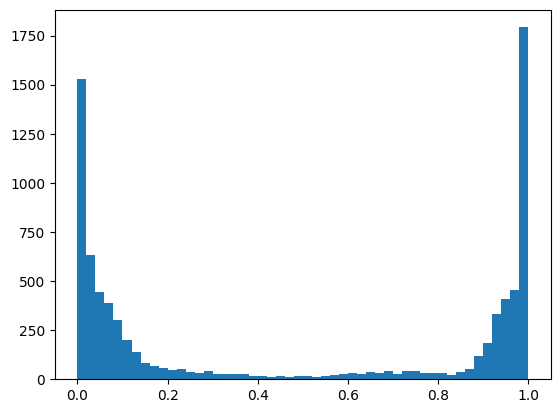

In [44]:
model = LogisticRegression()
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)
model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]
print(probs) # просто логистическая регрессия
plt.hist(probs, 50)
plt.show()

/tmp/ipykernel_2477363/352055501.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_c_e[col] = X_c_e[col].apply(lambda x: veroyatnost_e[x])
/tmp/ipykernel_2477363/352055501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_c_p[col] = X_c_p[col].apply(lambda x: veroyatnost_p[x])
/tmp/ipykernel_2477363/352055501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_2477363/352055501.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_c_e[col] = X_c_e[col].apply(lambda x: veroyatnost_e[x])
/tmp/ipykernel_2477363/352055501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_c_p[col] = X_c_p[col].apply(lambda x: veroyatnost_p[x])
/tmp/ipykernel_2477363/352055501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_2477363/352055501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_c_p[col] = X_c_p[col].apply(lambda x: veroyatnost_p[x])
/tmp/ipykernel_2477363/352055501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_c_e[col] = np.log(X_c_e[col]/(1-X_c_e[col])) # и делаем обратное логистическое преобразования
/tmp/ipykernel_2477363/352055501.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

[4.00856137e-04 3.47645620e-04 8.78615569e-07 ... 9.99982885e-01
 9.99522870e-01 9.99984438e-01]


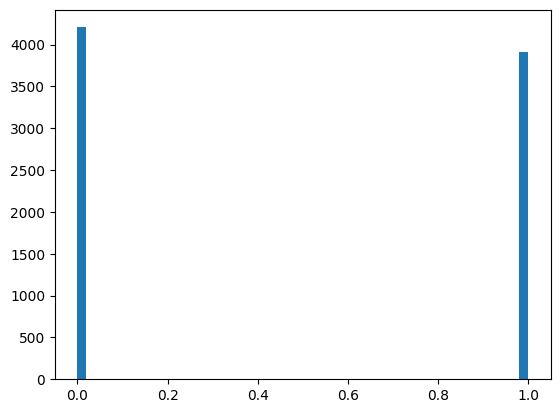

In [45]:
model = LogisticRegression()

X_c = X.copy()
X_c_e = X_c[y == 'e']
X_c_p = X_c[y == 'p']

for col in X_c.columns: # для каждой колонки считаем оценки вероятности
    veroyatnost_e = X_c_e[col].value_counts(normalize=True)
    veroyatnost_p = X_c_p[col].value_counts(normalize=True)
    
    X_c_e[col] = X_c_e[col].apply(lambda x: veroyatnost_e[x])
    X_c_p[col] = X_c_p[col].apply(lambda x: veroyatnost_p[x])
    
    X_c_e[col] = np.log(X_c_e[col]/(1-X_c_e[col])) # и делаем обратное логистическое преобразования
    X_c_p[col] = np.log(X_c_p[col]/(1-X_c_p[col])) # и делаем обратное логистическое преобразования
    
    X_c_e[col] = X_c_e[col].apply(lambda x: 0 if x == np.inf else x) # при оценке вероятности 1 получается бесконечность, зануляем
    X_c_p[col] = X_c_p[col].apply(lambda x: 0 if x == np.inf else x) # при оценке вероятности 1 получается бесконечность, зануляем

X_c = pd.concat([X_c_e, X_c_p])

y_c_e = y[y == 'e']
y_c_p = y[y == 'p']
y_c = pd.concat([y_c_e, y_c_p])

y_c = LabelEncoder().fit_transform(y_c)
model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]

print(probs) # с обратным логистическим преобразованием
plt.hist(probs, 50)
plt.show()

In [51]:
accuracy_score(np.where(probs >= 0.5, 1, 0), y_c)

1.0

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
veroyatnost_p

d    0.323800
p    0.257406
g    0.188968
l    0.151175
u    0.069459
m    0.009193
Name: habitat, dtype: float64